In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    FormFactorFile,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan, load_energy_scans,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import fit_differential_evolution, FitContext, FitTransform, TVRegularizer

In [4]:
o_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/O.ff")
sr_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Sr.ff")
ti_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Ti.ff")
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)

Current params: [3.8637948057808016, 2.496378890161917, 4.834399517466396, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0, 0.04, 1.0]
SrTiO3-crystal-Sr-roughness: 3.8637948057808016
SrTiO3-crystal-Ti-roughness: 2.496378890161917
SrTiO3-crystal-O-roughness: 4.834399517466396
SrTiO3-film-0-Sr-molar_density: 0.04
SrTiO3-film-0-Sr-roughness: 1.0
SrTiO3-film-0-Ti-molar_density: 0.04
SrTiO3-film-0-Ti-roughness: 1.0
SrTiO3-film-0-O-molar_density: 0.04
SrTiO3-film-0-O-roughness: 1.0
SrTiO3-film-1-Sr-molar_density: 0.04
SrTiO3-film-1-Sr-roughness: 1.0
SrTiO3-film-1-Ti-molar_density: 0.04
SrTiO3-film-1-Ti-roughness: 1.0
SrTiO3-film-1-O-molar_density: 0.04
SrTiO3-film-1-O-roughness: 1.0
SrTiO3-film-2-Sr-molar_density: 0.04
SrTiO3-film-2-Sr-roughness: 1.0
SrTiO3-film-2-Ti-molar_density: 0.04
SrTiO3-film-2-Ti-roughness: 1.0
SrTiO3-film-2-O-molar_density: 0.04
SrTiO3-film-2-O-roughness: 1.0
SrTi

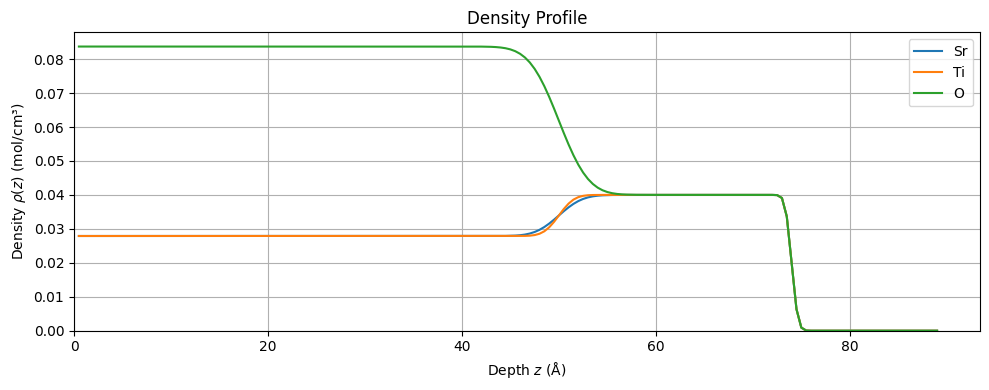

In [5]:
parameters_container = ParametersContainer()
crystal = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=2.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)

n_films = 5
init_thickness = 24.0
dthickness = init_thickness / n_films
density = 5.12
films = []
for i in range(n_films):
    film = create_compound(
        parameters_container=parameters_container,
        name=f"SrTiO3-film-{i}",
        formula="Sr:1,Ti:1,O:3",
        thickness=dthickness,
        density=density,
        atoms=[sr_atom, ti_atom, o_atom],
        roughness=1.0,
        prev_roughness=0.0,
        linked_prev_roughness=True,
    )
    films.append(film)

struc = Structure(name="SrTiO3-struc", n_compounds=n_films+1, params_container=parameters_container)
struc.add_compound(0, crystal)
for i, film in enumerate(films):
    struc.add_compound(i + 1, film)
struc.validate_compounds()

for detail in crystal.compound_details:
    detail.roughness.independent = True
    detail.roughness.fit = True
    detail.roughness.upper = 5.0
    detail.roughness.lower = 1.0

crystal.compound_details[0].roughness.set(3.8637948057808016)
crystal.compound_details[1].roughness.set(2.496378890161917)
crystal.compound_details[2].roughness.set(4.834399517466396)

def params_for_films(film):
    for detail in film.compound_details:
        detail.roughness.independent = True
        detail.roughness.fit = True
        detail.roughness.upper = 5.0
        detail.roughness.lower = 0.0

        detail.molar_density.independent = True
        detail.molar_density.fit = True
        detail.molar_density.set(0.04)
        detail.molar_density.upper = 0.09
        detail.molar_density.lower = 0

        detail.thickness.independent = False
        detail.thickness.fit = False
        # detail.thickness.upper = 7.0
        # detail.thickness.lower = 0.1

        detail.prev_roughness.independent = False
        detail.prev_roughness.fit = False
        # detail.prev_roughness.upper = 5.0
        # detail.prev_roughness.lower = 0.0


for film in films:
    params_for_films(film)

struc.create_layers(step=0.5)

def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")


# print(f"Number of layers: {struc.n_layers}")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

In [12]:
experimental_rscans = load_reflectivity_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_AScans.dat',
    initial_name='B074_AScans',
)
experimental_escans = load_energy_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_EScans.dat',
    initial_name='B074_EScans',
)

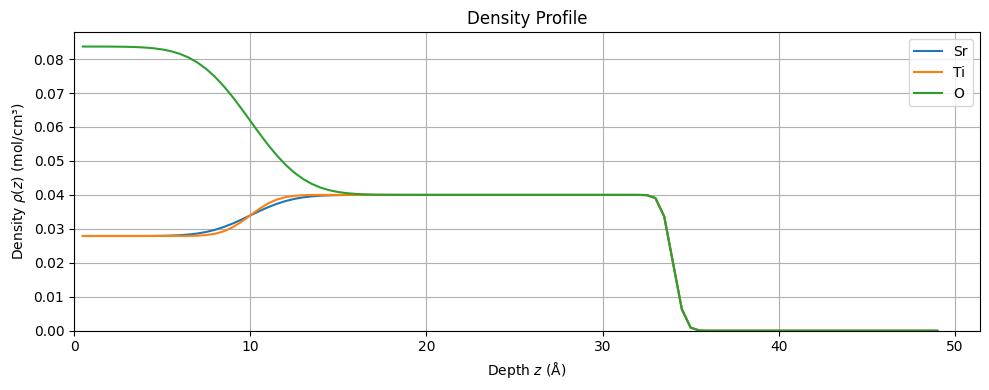

In [7]:
for film in films:
    for detail in film.compound_details:
        detail.roughness.fit = True
        detail.molar_density.fit = True
        detail.thickness.fit = False

crystal.thickness.set(10)
struc.update_layers()
plot_density_profile_atoms_layers(struc.atoms_layers)

In [8]:
backend = PRParallelReflectivityBackend(als=True)
scale_param = parameters_container.new_parameter("scale", value=1.0, fit=False)
offset_param = parameters_container.new_parameter("offset", value=0.0, fit=False)

context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln", sim_scale=scale_param, sim_offset=offset_param),
    tv=TVRegularizer(),
    objective="chi2",
)
parameters = [
    param for param in parameters_container.parameters if param.fit
]

print(len(parameters))

res = fit_differential_evolution(
    params=parameters,
    ctx=context,
    ref_scans=[],
    en_scans=experimental_escans,
    popsize=6,
)


print(res)
print("Final parameters:")
print_parameters(parameters_container)

33
Data ready
differential_evolution step 1: f(x)= 356836.65595524444
differential_evolution step 2: f(x)= 354705.6976937325
differential_evolution step 3: f(x)= 323111.02001141943
differential_evolution step 4: f(x)= 323111.02001141943
differential_evolution step 5: f(x)= 322261.92830833636
differential_evolution step 6: f(x)= 322261.92830833636
differential_evolution step 7: f(x)= 322261.92830833636
differential_evolution step 8: f(x)= 311522.23549470154
differential_evolution step 9: f(x)= 308159.90560071566
differential_evolution step 10: f(x)= 308159.90560071566
differential_evolution step 11: f(x)= 308159.90560071566
differential_evolution step 12: f(x)= 308159.90560071566
differential_evolution step 13: f(x)= 305992.14827451005
differential_evolution step 14: f(x)= 305992.14827451005
differential_evolution step 15: f(x)= 305992.14827451005
differential_evolution step 16: f(x)= 305992.14827451005
differential_evolution step 17: f(x)= 305992.14827451005
differential_evolution step

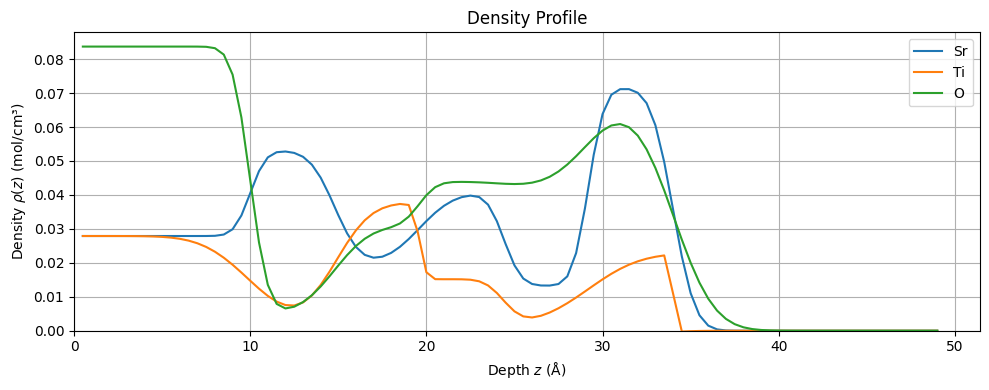

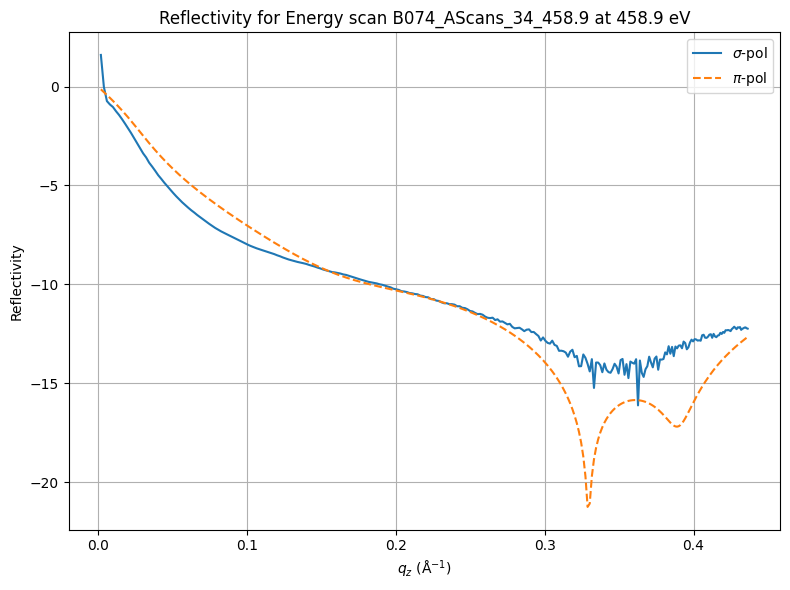

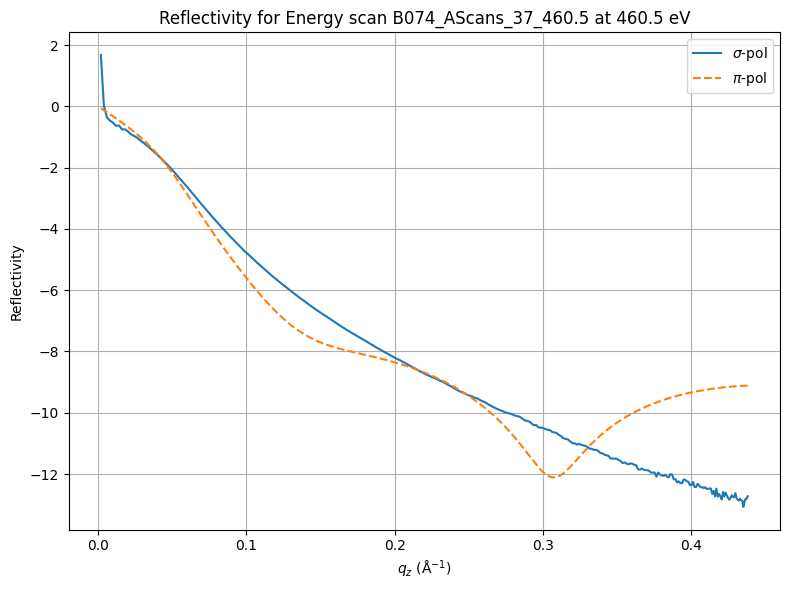

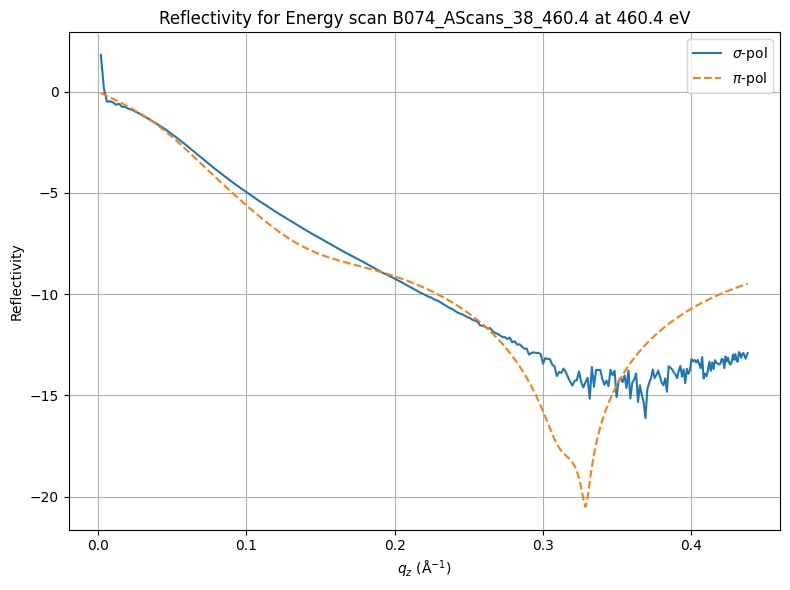

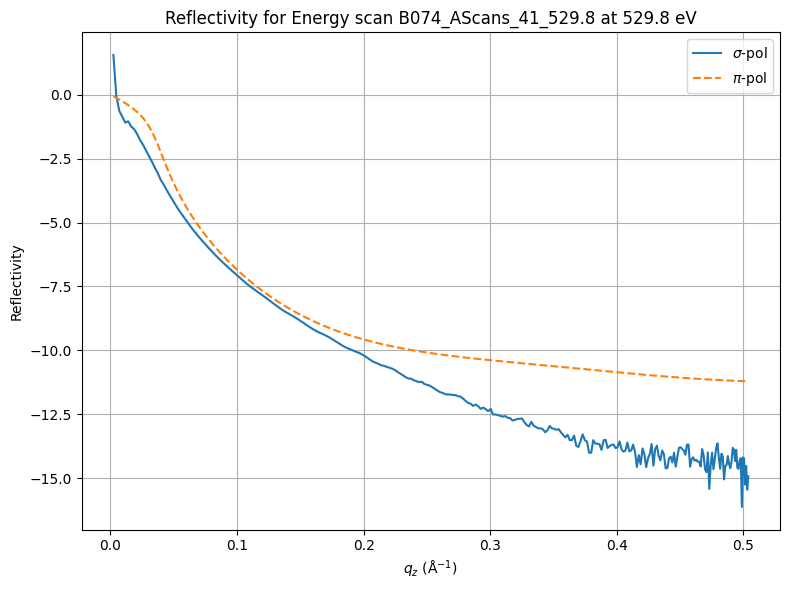

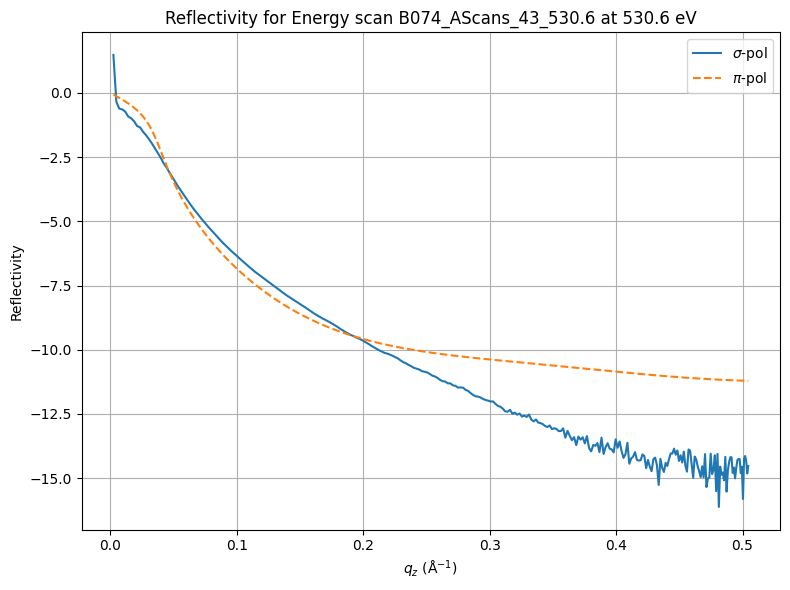

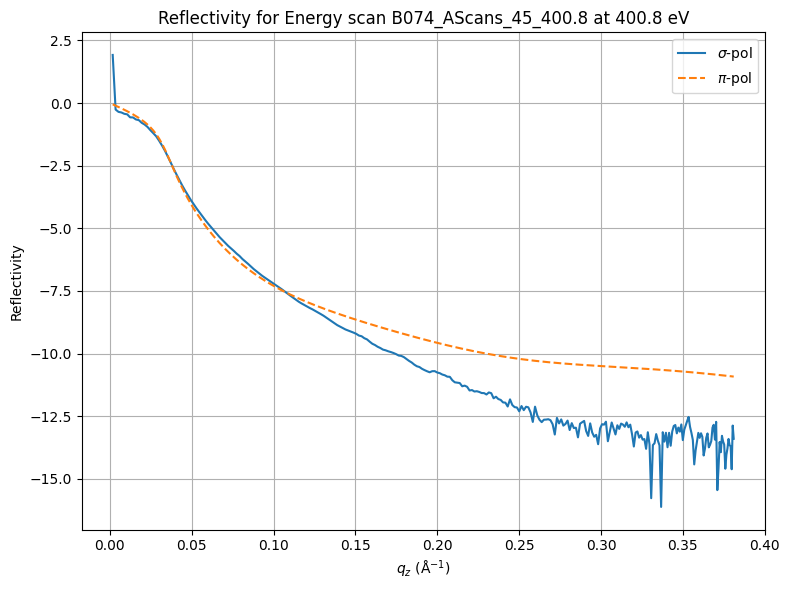

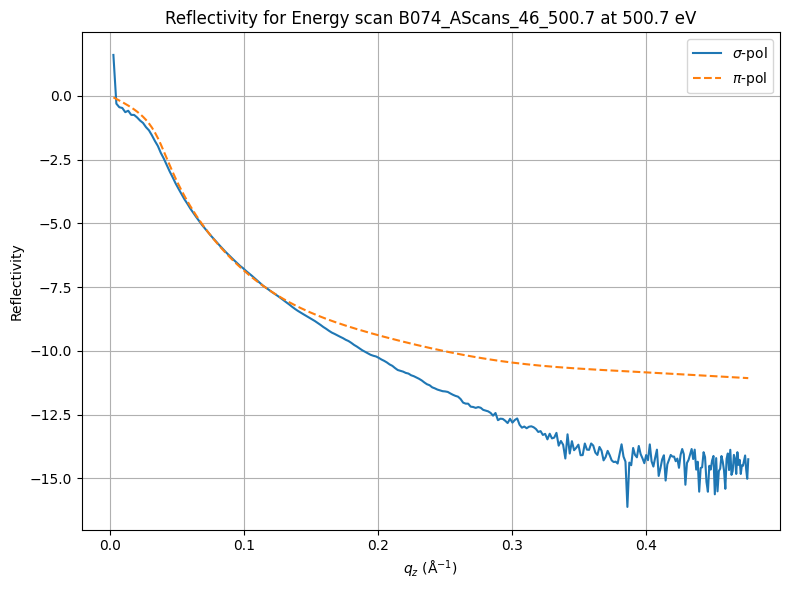

In [10]:
crystal.thickness.set(10)
struc.update_layers()
plot_density_profile_atoms_layers(struc.atoms_layers)
for rscan in experimental_rscans[5:12]:
    rsim = backend.compute_reflectivity(structure=struc, qz=rscan.qz, energy=rscan.energy_eV)
    r = rsim.R_s if rscan.pol == "s" else rsim.R_p

    plot_reflectivity(rscan.qz, np.log(rscan.R), np.log(r), rscan.energy_eV, f"Energy scan {rscan.name}")

Initial parameters:
Current params: [2.196917314595915, 2.5910755330932753, 3.5399119280579985, 0.029776221516464377, 2.5374288088958874, 0.02191243758041929, 2.401421107336326, 0.03762138451495314, 0.8204214967645727, 0.025508975370324427, 1.4699996109091484, 0.0384265690512097, 0.2834396367499674, 0.019289219219730275, 3.8810906406361627, 0.026291026919270048, 2.732435723027004, 0.02637021094283215, 3.9279130189804645, 0.04845953052127307, 2.8377697564276656, 0.028362691697693034, 3.151544464201196, 0.022340611439236702, 3.494144039437812, 0.001114768574900754, 1.7955672217116125]
SrTiO3-crystal-Sr-roughness: 2.196917314595915
SrTiO3-crystal-Ti-roughness: 2.5910755330932753
SrTiO3-crystal-O-roughness: 3.5399119280579985
SrTiO3-film-0-Sr-molar_density: 0.029776221516464377
SrTiO3-film-0-Sr-roughness: 2.5374288088958874
SrTiO3-film-0-Ti-molar_density: 0.02191243758041929
SrTiO3-film-0-Ti-roughness: 2.401421107336326
SrTiO3-film-0-O-molar_density: 0.03762138451495314
SrTiO3-film-0-O-rou

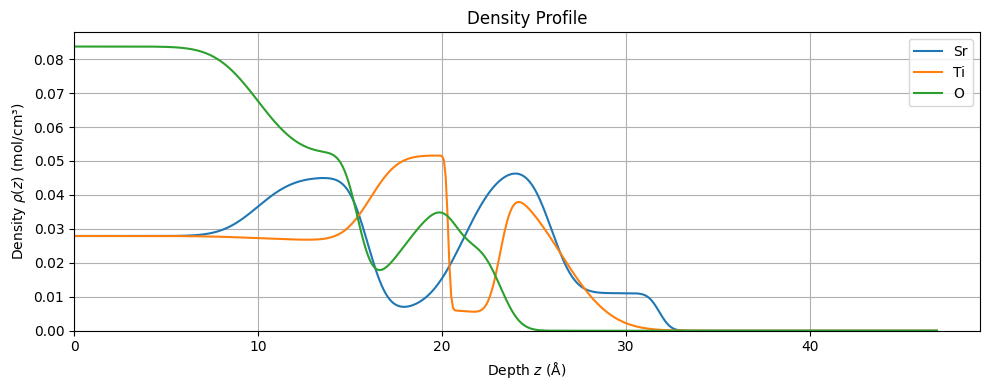

In [47]:
print("Initial parameters:")
print_parameters(parameters_container)

parameters = [
    param for param in parameters_container.parameters if param.fit
]

print(len(parameters))

res = fit_differential_evolution(
    params=parameters,
    ctx=context,
    ref_scans=experimental_rscans[0:5],
    en_scans=[],
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

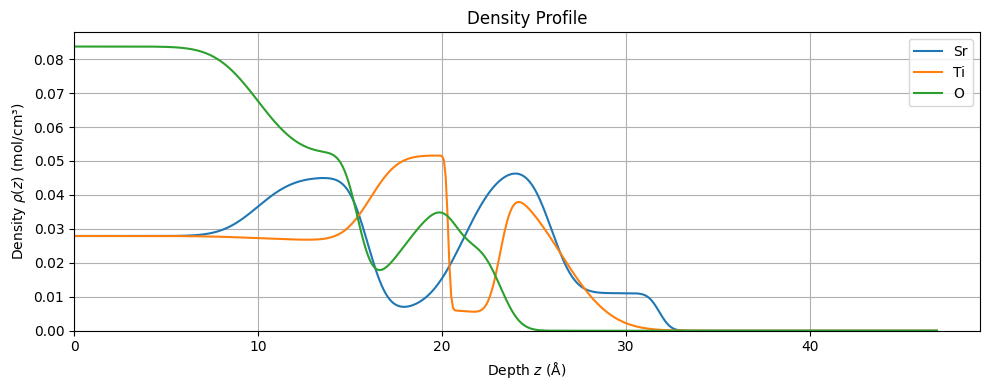

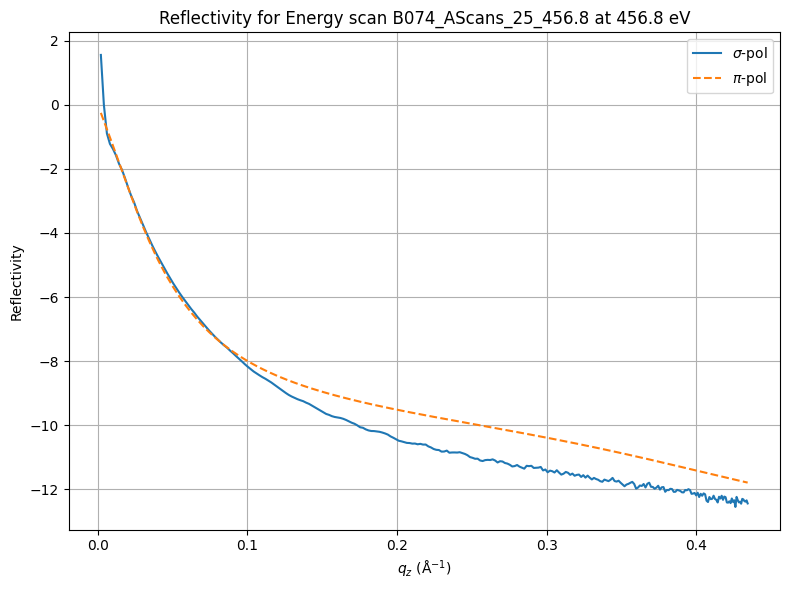

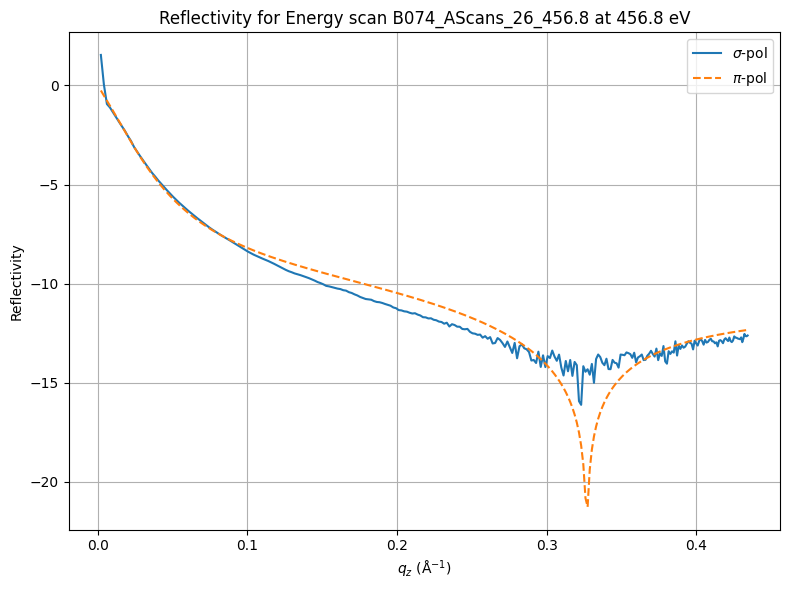

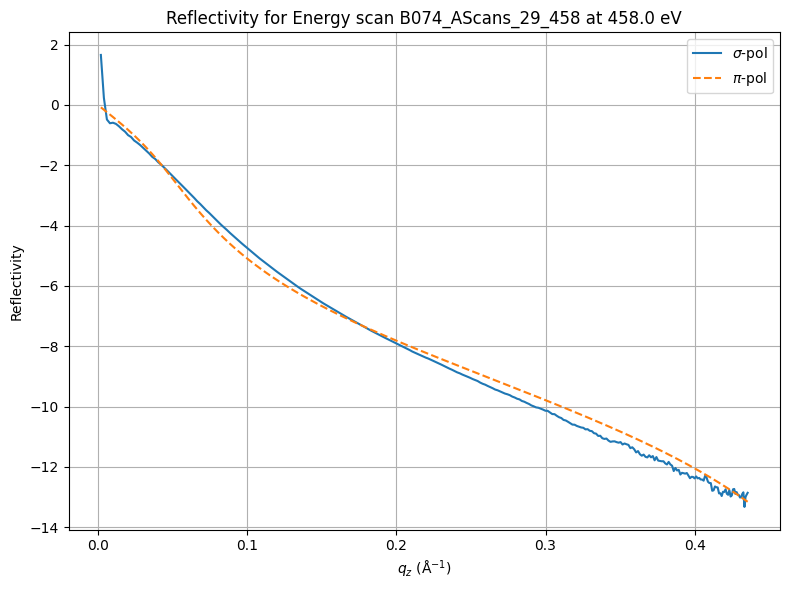

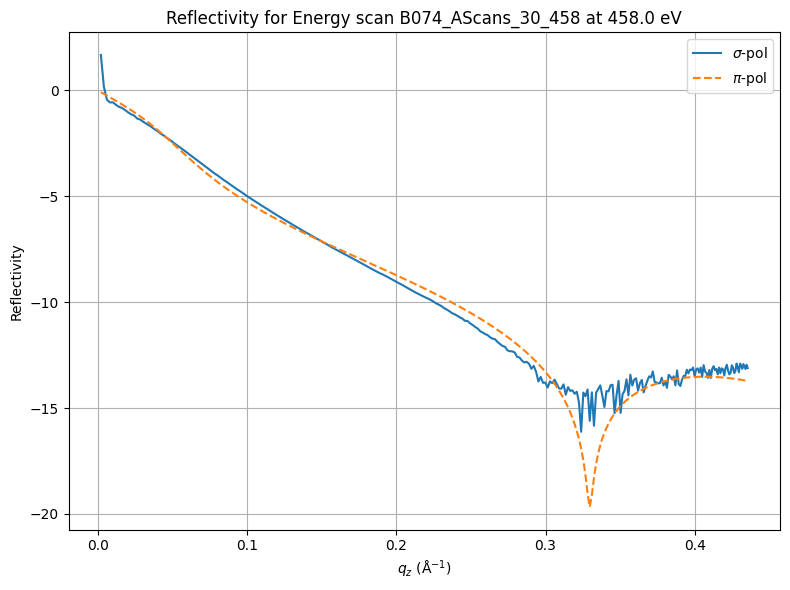

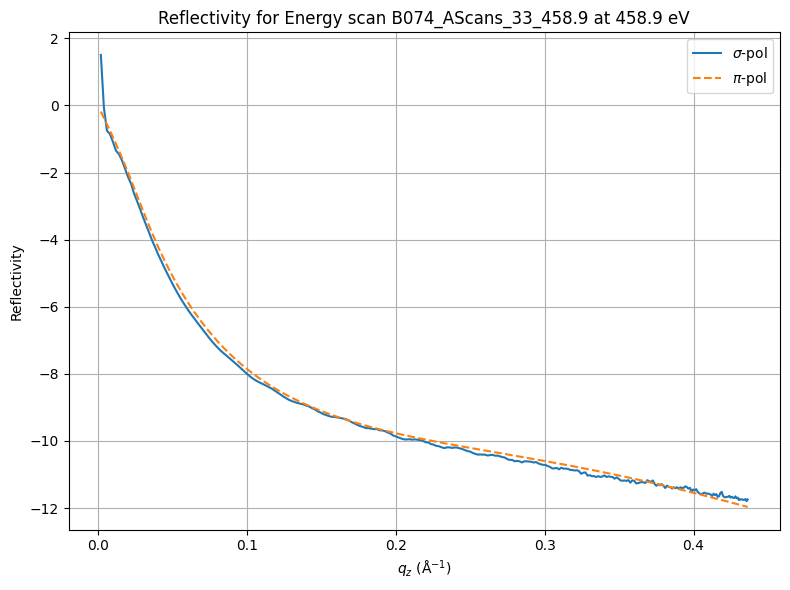

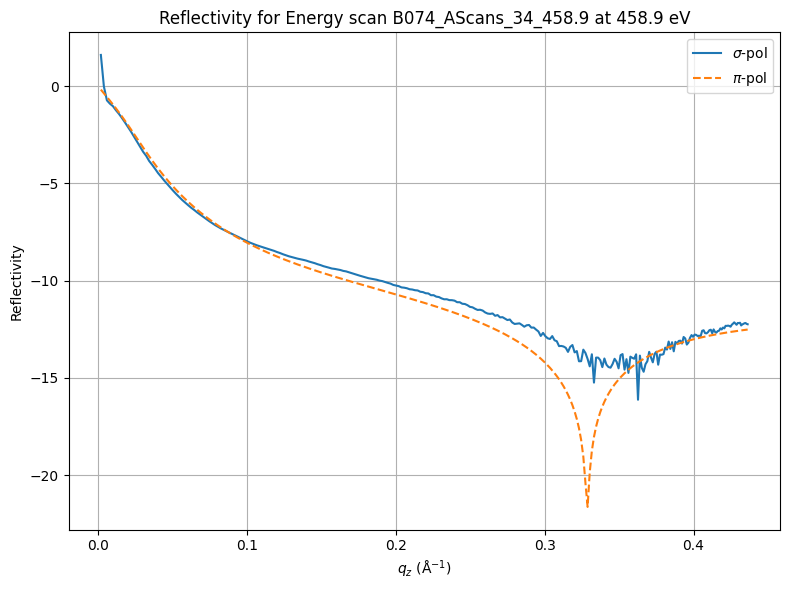

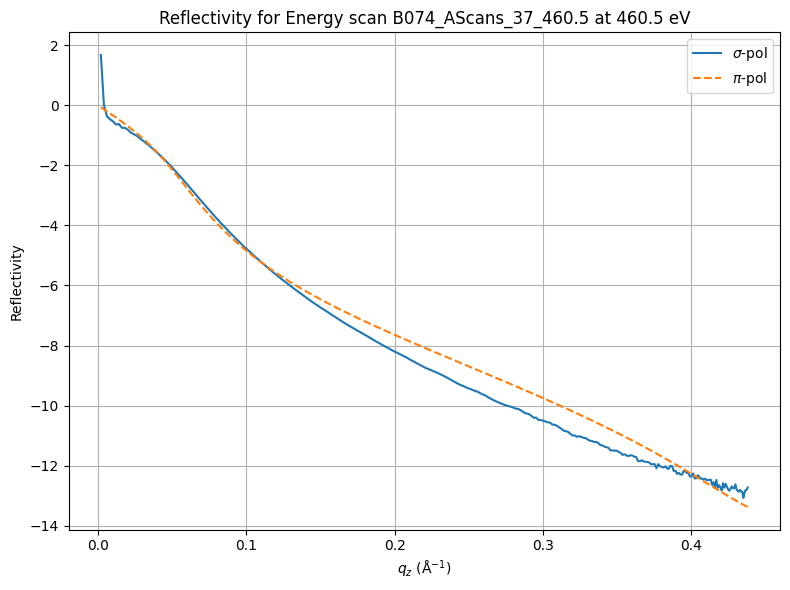

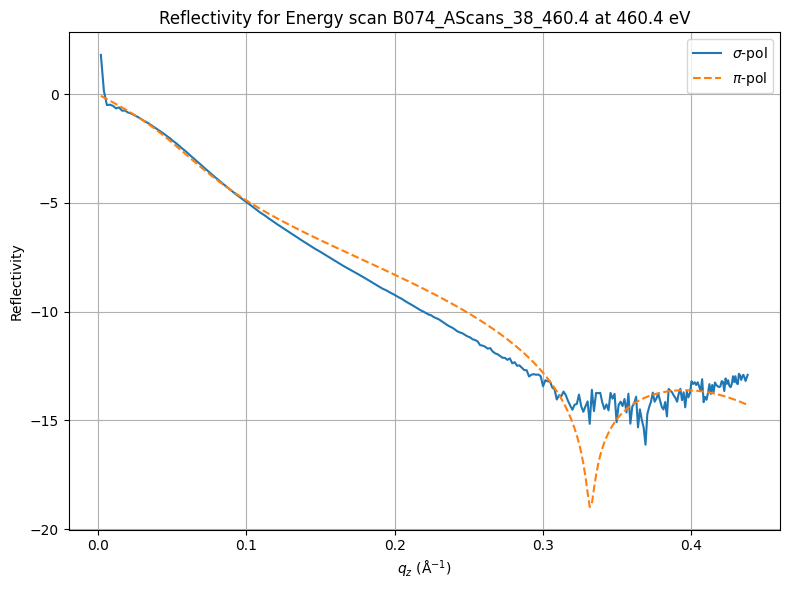

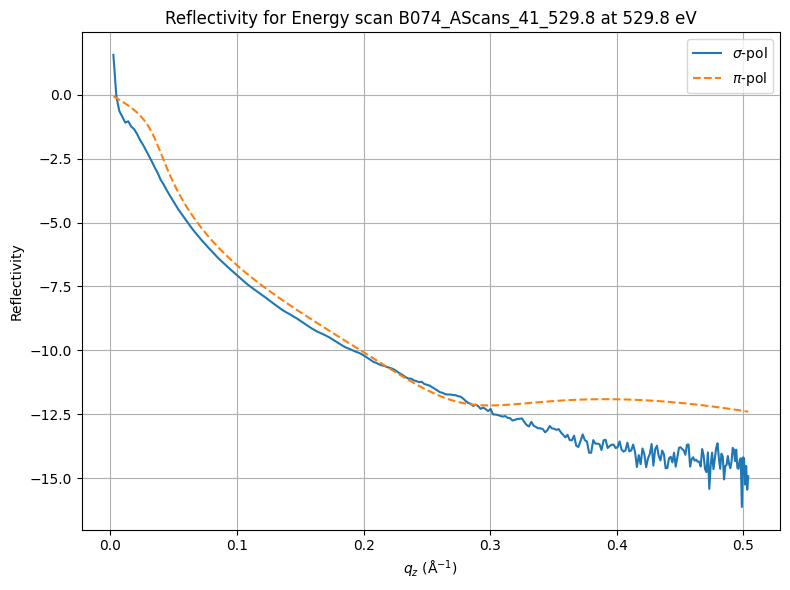

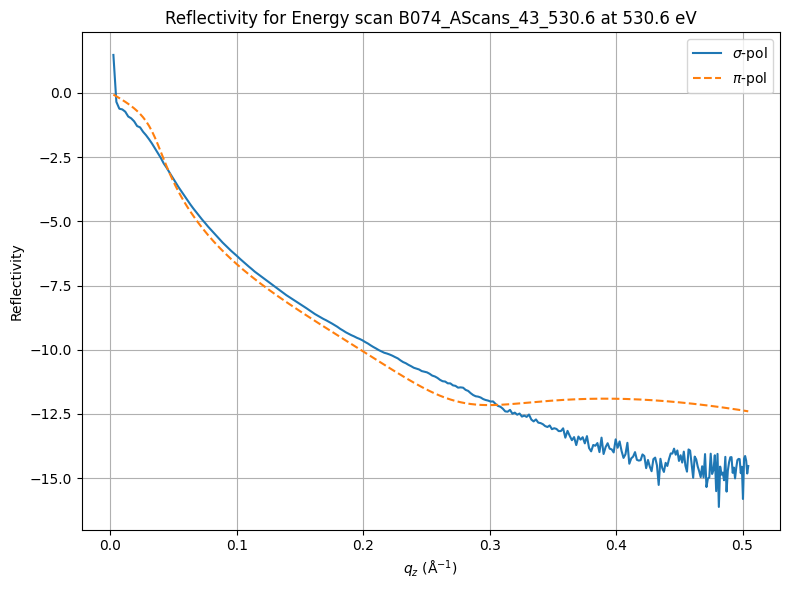

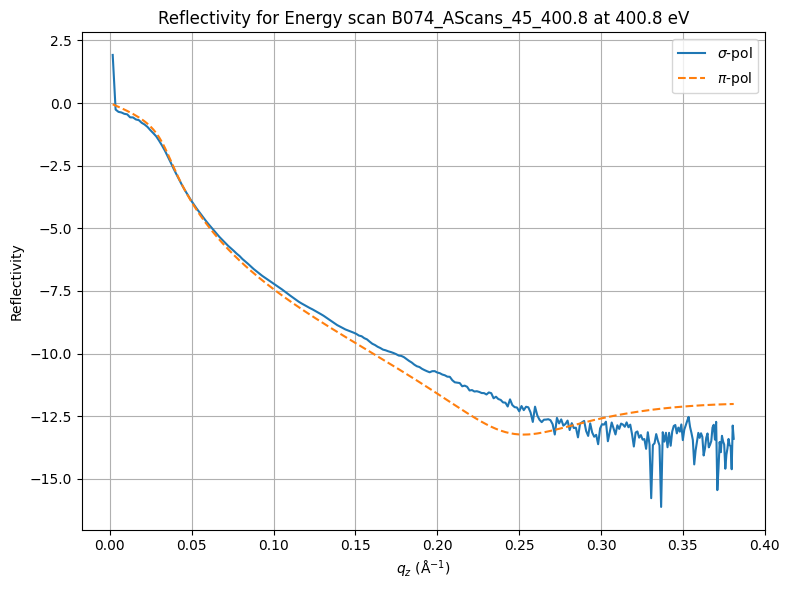

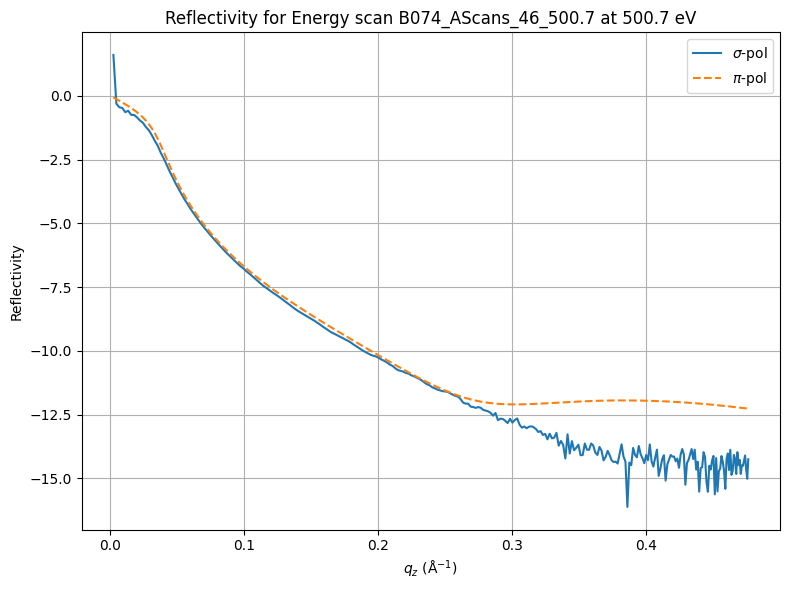

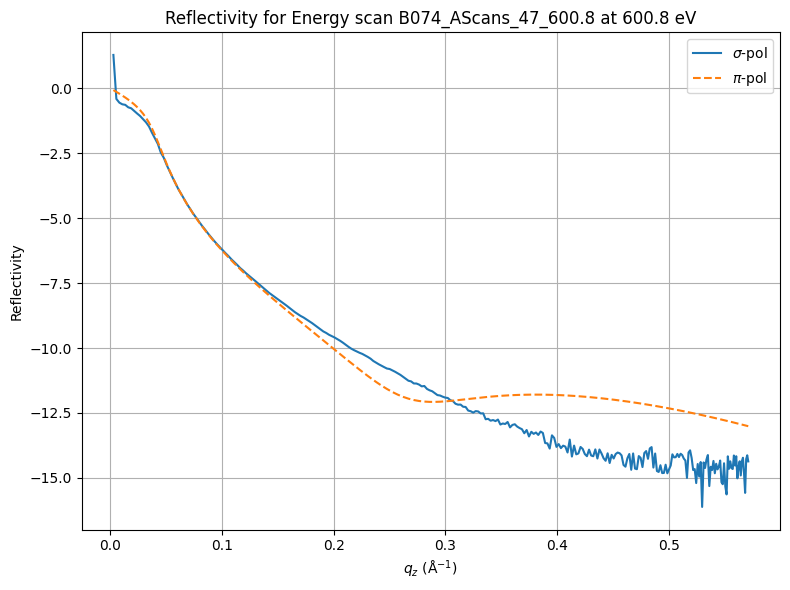

In [52]:
crystal.thickness.set(10)
struc.update_layers()
plot_density_profile_atoms_layers(struc.atoms_layers)
for rscan in experimental_rscans:
    rsim = backend.compute_reflectivity(structure=struc, qz=rscan.qz, energy=rscan.energy_eV)
    r = rsim.R_s if rscan.pol == "s" else rsim.R_p

    plot_reflectivity(rscan.qz, np.log(rscan.R), np.log(r), rscan.energy_eV, f"Energy scan {rscan.name}")

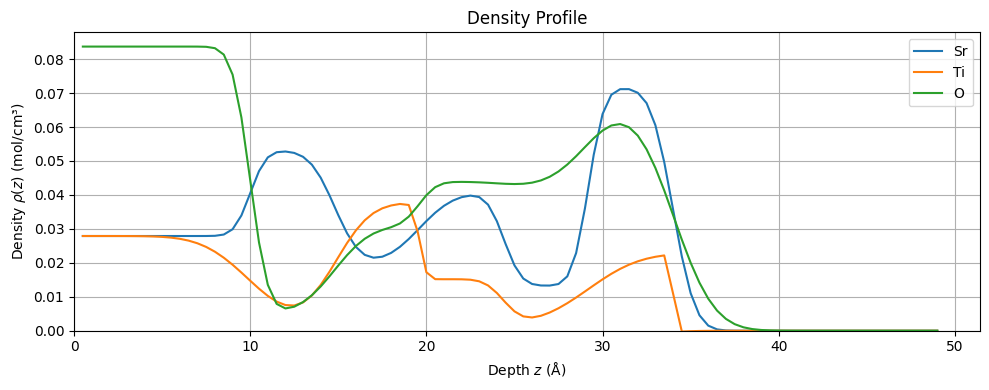

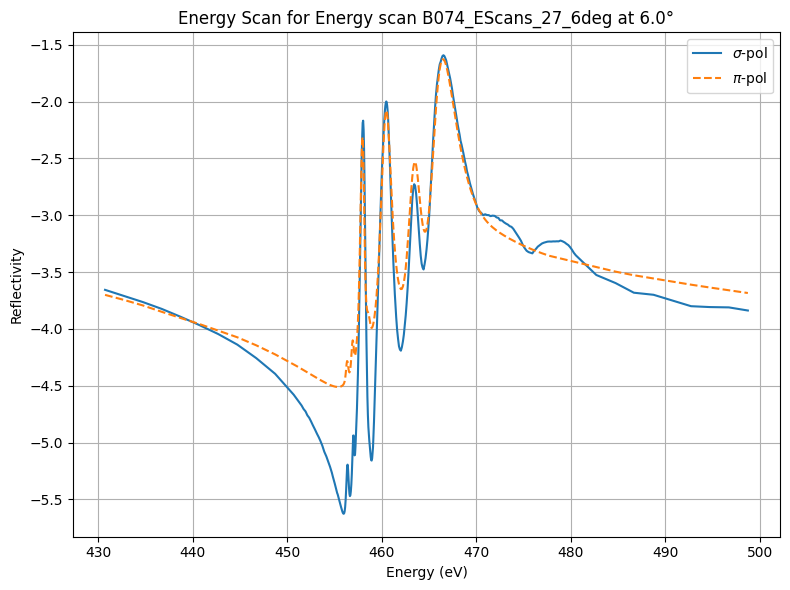

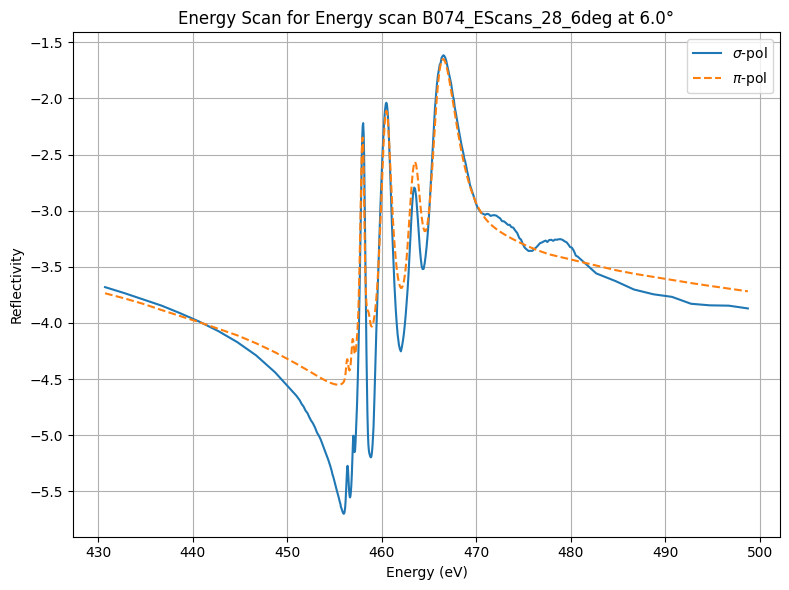

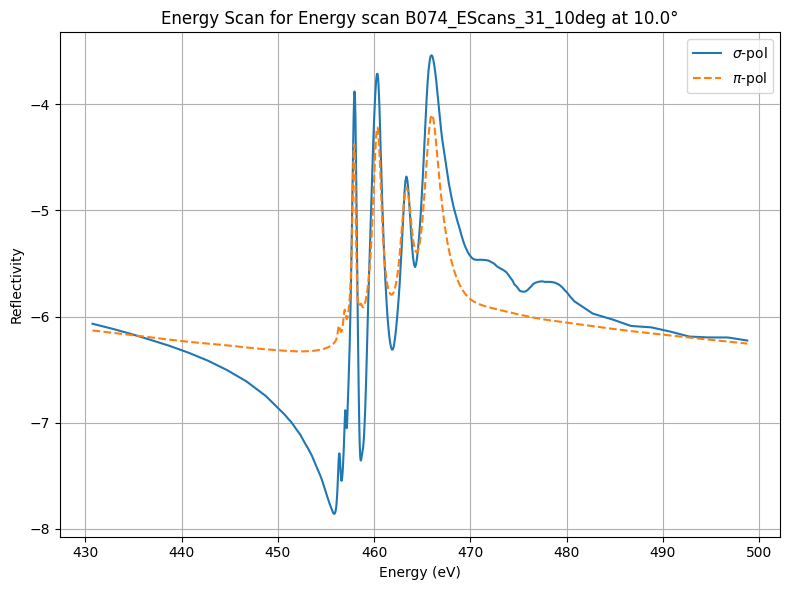

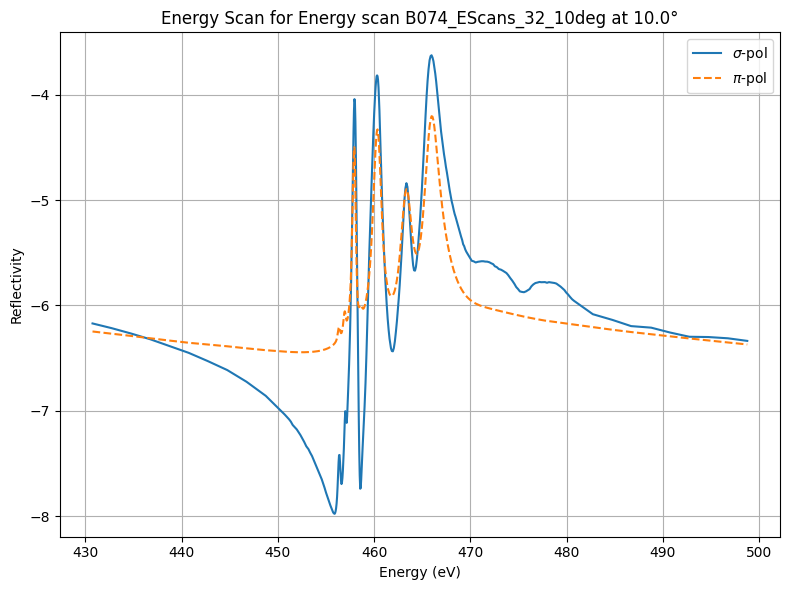

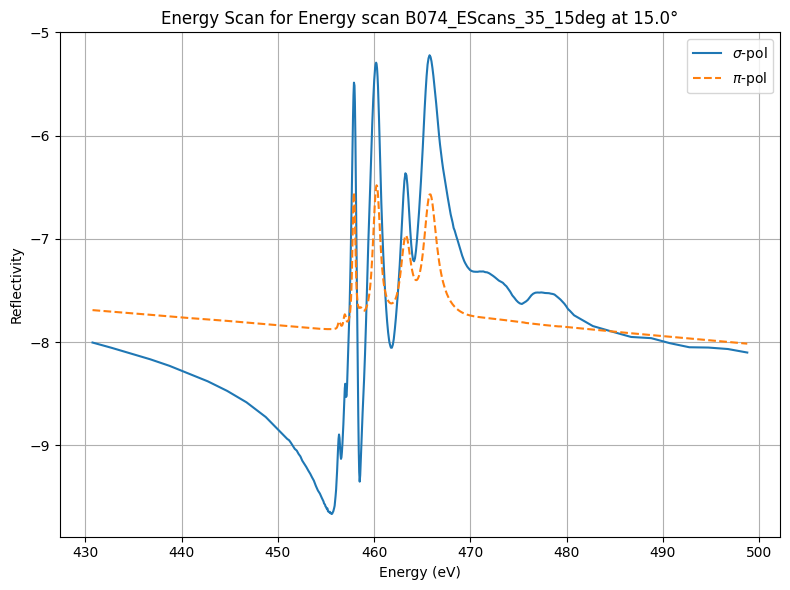

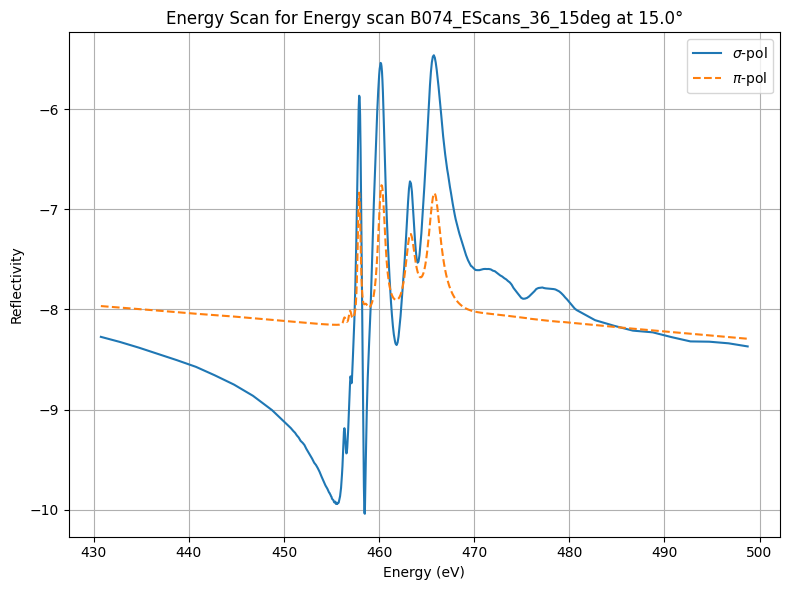

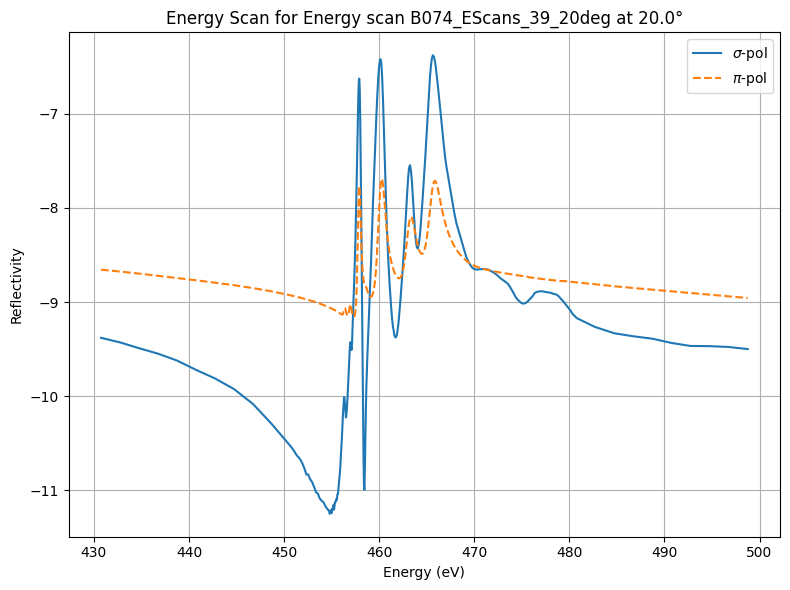

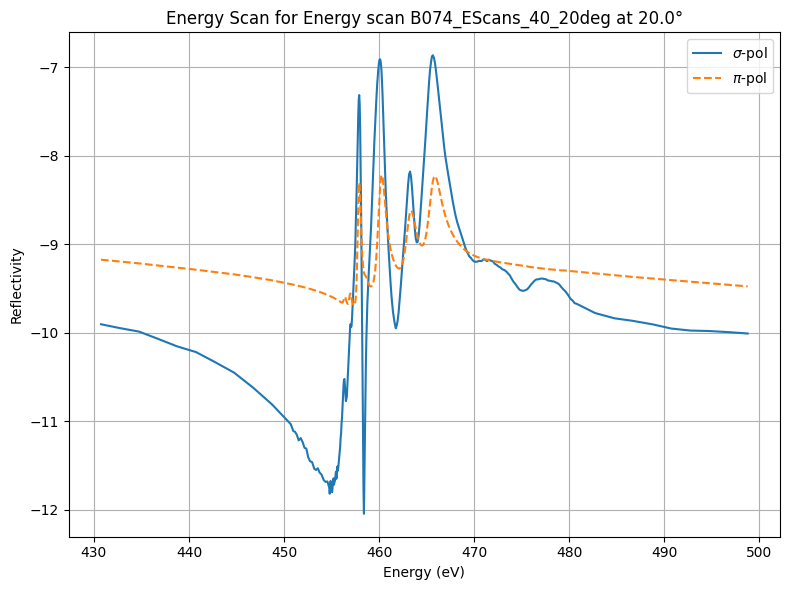

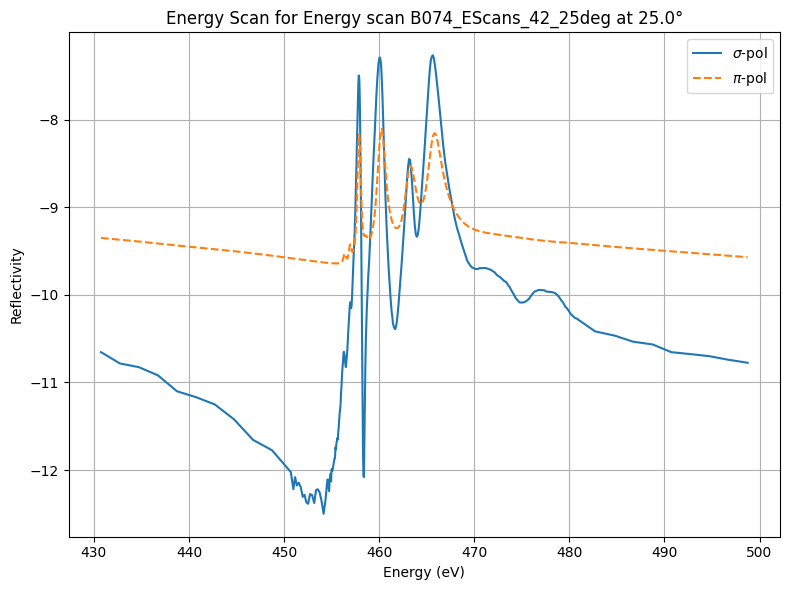

In [13]:
crystal.thickness.set(10)
struc.update_layers()
plot_density_profile_atoms_layers(struc.atoms_layers)
for escan in experimental_escans:
    rsim = backend.compute_energy_scan(structure=struc, energy_range=escan.E_eV, theta=escan.theta_deg)
    r = rsim.R_s if escan.pol == "s" else rsim.R_p

    plot_energy_scan(escan.E_eV, np.log(escan.R), np.log(r), escan.theta_deg, f"Energy scan {escan.name}")

In [32]:
def params_for_films(film):
    for detail in film.compound_details:
        detail.roughness.independent = False
        detail.roughness.fit = False
        detail.roughness.upper = 5.0
        detail.roughness.lower = 0.0

        detail.molar_density.independent = False
        detail.molar_density.fit = False
        detail.molar_density.upper = 0.09
        detail.molar_density.lower = 0

        detail.thickness.independent = True
        detail.thickness.fit = True
        detail.thickness.set(6)
        detail.thickness.upper = 7.0
        detail.thickness.lower = 1.0

        detail.prev_roughness.independent = False
        detail.prev_roughness.fit = False
        # detail.prev_roughness.upper = 5.0
        # detail.prev_roughness.lower = 0.0


for film in films:
    params_for_films(film)

print_parameters(parameters_container)


Current params: [2.2153869876788987, 2.4675075180906223, 3.033646435732006, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
SrTiO3-crystal-Sr-roughness: 2.2153869876788987
SrTiO3-crystal-Ti-roughness: 2.4675075180906223
SrTiO3-crystal-O-roughness: 3.033646435732006
SrTiO3-film-0-Sr-thickness: 6
SrTiO3-film-0-Ti-thickness: 6
SrTiO3-film-0-O-thickness: 6
SrTiO3-film-1-Sr-thickness: 6
SrTiO3-film-1-Ti-thickness: 6
SrTiO3-film-1-O-thickness: 6
SrTiO3-film-2-Sr-thickness: 6
SrTiO3-film-2-Ti-thickness: 6
SrTiO3-film-2-O-thickness: 6
SrTiO3-film-3-Sr-thickness: 6
SrTiO3-film-3-Ti-thickness: 6
SrTiO3-film-3-O-thickness: 6
